In [10]:
!pip install -q efficientnet >> /dev/null

In [11]:
import os

import efficientnet.tfkeras as efn
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import glob
import random

print("Using TensorFlow version", tf.__version__)

Using TensorFlow version 2.6.0


In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16
IMAGE_SIZE = (150, 150)
EPOCHS = 5

In [13]:
files = glob.glob('../input/chest_xray/train/*/*')
files.extend(glob.glob('../input/chest_xray/val/*/*'))
random.shuffle(files)
train_files, val_files = train_test_split(files, test_size=0.2)

In [14]:
print("Image Counts In Training Set: ")
print("Normal images:", len([file for file in train_files if "NORMAL" in file]))
print("Pneumonia images:", len([file for file in train_files if "PNEUMONIA" in file]))

Image Counts In Training Set: 
Normal images: 1078
Pneumonia images: 3107


In [15]:
# Create dataset
train_list_ds = tf.data.Dataset.from_tensor_slices(train_files)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_files)

In [16]:
CLASS_NAMES = os.listdir("../input/chest_xray/train/")
CLASS_NAMES

['PNEUMONIA', 'NORMAL']

In [17]:
@tf.function
def process_path(file_path):
  path_parts = tf.strings.split(file_path, sep=os.path.sep)
  cls = path_parts[-2]
  label = (0 if cls == "PNEUMONIA" else 1)
  img = tf.io.read_file(file_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, IMAGE_SIZE)
  return img, label

In [18]:
@tf.function
def data_augmentation(image, label):
  image = tf.image.random_flip_left_right(image)
  return image, label

In [19]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [20]:
test_list_ds = tf.data.Dataset.list_files('../input/chest_xray/test/*/*')
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

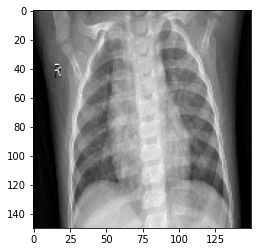

In [21]:
test_img, test_label = next(iter(test_ds))
plt.imshow(test_img[0])
del test_img, test_label

In [22]:
@tf.function
def prepare(ds, augment=False):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    if augment:
      ds = ds.map(data_augmentation, num_parallel_calls=AUTOTUNE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [23]:
train_ds = prepare(train_ds, augment=True)
val_ds = prepare(val_ds)

In [24]:
NORMAL_AMOUNT = len([filename for filename in train_files if "NORMAL" in filename])
PNEUMONIA_AMOUNT = len([filename for filename in train_files if "PNEUMONIA" in filename])
TRAIN_AMOUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
VAL_AMOUNT = tf.data.experimental.cardinality(val_list_ds).numpy()

WEIGHT_FOR_0 = (1 / NORMAL_AMOUNT)*(TRAIN_AMOUNT)/2.0 
WEIGHT_FOR_1 = (1 / PNEUMONIA_AMOUNT)*(TRAIN_AMOUNT)/2.0

class_weight = {0: WEIGHT_FOR_0, 1: WEIGHT_FOR_1}

print('Weight for class 0: {:.2f}'.format(WEIGHT_FOR_0))
print('Weight for class 1: {:.2f}'.format(WEIGHT_FOR_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


In [26]:
def create_model():
  inp = tf.keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
  base = efn.EfficientNetB0(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),weights='imagenet', include_top=False)
  x = base(inp)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
  model = tf.keras.Model(inputs=inp, outputs=x)
  return model

In [27]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = create_model()

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

16818176/16804768 [==============================] - 0s 0us/step


In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

In [29]:
history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, class_weight=class_weight, callbacks=[early_stopping])

Epoch 1/5
262/262 [==============================] - 532s 2s/step - loss: 0.1545 - accuracy: 0.9422 - val_loss: 1.5694 - val_accuracy: 0.7479
Epoch 2/5
262/262 [==============================] - 480s 2s/step - loss: 0.0680 - accuracy: 0.9749 - val_loss: 0.0863 - val_accuracy: 0.9733
Epoch 3/5
262/262 [==============================] - 478s 2s/step - loss: 0.0606 - accuracy: 0.9785 - val_loss: 0.0808 - val_accuracy: 0.9675
Epoch 4/5
262/262 [==============================] - 473s 2s/step - loss: 0.0375 - accuracy: 0.9864 - val_loss: 0.0302 - val_accuracy: 0.9904
Epoch 5/5
262/262 [==============================] - 485s 2s/step - loss: 0.0356 - accuracy: 0.9876 - val_loss: 0.0288 - val_accuracy: 0.9895


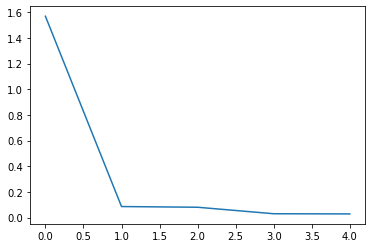

In [30]:
training_info = pd.DataFrame(history.history)
training_info['val_loss'].plot()

### End Remarks
I learned a lot about transfer learning and adding class weights. I also learned a lot about TensorFlow's API. More metrics can be put into place to make the model better, but for a small project, this model is fine.